# Description
Notebook to compare the redshift power spectrum deduced from the data to Kaiser's linear theory. The chosen cosmology, BoxSize, LOS, redshift is the same as those used in the generation of the mock data (see header of file or README in data directory). The linear bias is left as a free parameter and later fixed such that $\chi^2$ between data and linear theory is minimal.

Since data file is large, keep it in a separate directory.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
from scipy.special import legendre
from scipy.integrate import simpson
import scipy.sparse as ss
import cat_power_algos as catpk

from nbodykit.lab import *
from nbodykit import style, setup_logging
#setup_logging()
plt.style.use(style.notebook)

In [3]:
filename = '/home/jwack/power_mockdata/HMQELG-eBOSS-density.gcat' 

cosmo = cosmology.Planck15
BoxSize = 1000
LOS = [0,0,1]
redshift = 0

Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')

### Gaussian covariance matrices
Based on Grieb et al. 2016 (https://arxiv.org/pdf/1509.04293.pdf)


Formula for $\chi^2$, for data vector $D=\begin{bmatrix} P_0(k) \\ P_2(k) \end{bmatrix}$, model vector $M=\begin{bmatrix} P^{model}_0(k) \\ P^{model}_2(k) \end{bmatrix}$ and covariance matrix $C$:
$$\chi^2 = \sum_{k bins} (D-M)C^{-1}(D-M)^T$$
With the Gaussian covariance matrix:
$$C=\begin{bmatrix} C_{00} & C_{02} \\ C_{20} & C_{22}\end{bmatrix}, \quad C_{l_1l_2}=diag(\sigma^2_{l_1l_2}(k))$$ 
where $\sigma^2_{l_1l_2}(k)$ is given by eq 15. Note that C is symmetric. 

In [4]:
def kaiser_pkmu(k, mu, b1):
    """Returns power spectrum in redshift space, following Kaiser's linear results."""
    beta = cosmo.scale_independent_growth_rate(redshift) / b1 
    return (1 + beta*mu**2)**2 *b1**2 * Plin(k)


# calling damped_kaiser_pkmu instead of kaiser_pkmu in for loop of make_Pkmu leads to no improvement of chi2 for
# small sigma and significant worsening for large sigma
def damped_kaiser_pkmu(k, mu, b1):
    '''Uses phenomenological model to account for non-linearity by damping Kaisers prediction for large k.
    The conventional value of sigma is about 400 km/s.'''
    sigma = np.sqrt(2) # km/s
    return np.exp(-0.5*(sigma*k*mu)**2)*kaiser_pkmu(k, mu, b1)


def make_Pkmu(k, b1):
    '''Make 2D array containing the model P(k,mu) with rows iterating k bins and columns iterating mu bins.
    Later seek to integrate up each row i.e. integrate over mu. Nmu defines the discretiation.'''
    Nmu = 50
    mus = np.linspace(-1,1,Nmu)
    Pkmu = np.empty((len(k), Nmu))
    
    for i,mu in enumerate(mus):
        Pkmu[:,i] = kaiser_pkmu(k,mu,b1)
        
    return Pkmu, mus


def kaiser_multipole(k, ell, b1):
    '''Compute ell-th multipole of Kaiser P(k,mu) by projecting on Legendre polynominal. See eq 3.'''
    Pkmu, mus = make_Pkmu(k, b1)
    L_ell = legendre(ell)(mus)
    integrand = L_ell*Pkmu # each column gets multiplied by value of Legendre poly at assocaiated mu

    return (2*ell+1)/2 * simpson(integrand, mus) # integrate up all rows separtely


def per_mode_cov(k, l1, l2, b1, shotnoise):
    '''Construct per mode covariance. See eq 15 of Grieb et al. (2016).'''
    V = BoxSize**3
    Pkmu, mus = make_Pkmu(k, b1)
    L_l1, L_l2 = legendre(l1)(mus), legendre(l2)(mus)
    integrand = (Pkmu + shotnoise)**2 * L_l1*L_l2
    
    return (2*l1+1)**2 * (2*l2+1)**2 / V * simpson(integrand, mus) # 1D array containing per mode cov for each k bin


def gaussian_cov_mat_inv(k, ells, b1, shotnoise):
    '''See above markdown for explanation of structure of covariance matrix. Uses sparse matricies for fast inversion.
    scipy.sparse.bmat allows to combine matricies by passing structure of larger matrix in terms of submatricies.'''
    # initialize array accepting matricies as elements and fill with diagonal C_l1,l2 matricies
    C = np.empty((len(ells), len(ells)), dtype='object')
    for i,l1 in enumerate(ells):
        for j,l2 in list(enumerate(ells))[i:]:
            C[i][j] = ss.diags(per_mode_cov(k,l1,l2,b1,shotnoise))
            if j!=i:
                C[j][i] = C[i][j]
                
    cov_mat = ss.bmat(C).tocsc() # convert to efficient scipy matrix format
     
    return ss.linalg.inv(cov_mat).toarray()
    
    
def chi2(b1, k, ells, data_multipole, shotnoise):
    '''Find chi^2 according to markdown. The theoretical Gaussian covariance matrix is used to estimate the data error.'''
    # make model vector
    model_multipole = np.empty((len(ells), len(k)))
    for i,ell in enumerate(ells):
        model_multipole[i] = kaiser_multipole(k,ell,b1)
        
    D_M = (data_multipole - model_multipole).flatten()
    C_inv = gaussian_cov_mat_inv(k, ells, b1, shotnoise)
    
    return D_M@(C_inv @ D_M)

Find power spectrum up to largest kmax we want to consider. Then perform fitting of b1 by using more and more
bins of the computed power spectrum. Equivalent to computing power spectrum again and again for increasing kmax which
would imply repeating the same computation several times.

In [10]:
ells = [0,2]
k_min = 0
k_max_upper = 0.15
dk = 0.01
Nmesh = 128

b1_fits, chi2_mins = [], []

cat = catpk.make_cat(filename, cosmo=cosmo, LOS=LOS, z=redshift)
mesh = cat.to_mesh(position='RSDPosition', resampler='tsc', BoxSize=BoxSize, Nmesh=Nmesh, compensated=True)

%time poles = FFTPower(mesh, mode='2d', los=LOS, poles=ells, dk=dk, kmin=k_min, kmax=k_max_upper).poles
k, shotnoise  = poles['k'], poles.attrs['shotnoise']

data_multipoles = np.empty((len(ells), len(k)))

for i,ell in enumerate(ells):
    Pk_ell = poles['power_%d' %ell].real
    if ell == 0: 
        Pk_ell = Pk_ell - shotnoise
    data_multipoles[i] = Pk_ell

for i in range(len(k)):
    t1 = time.time()
    s = minimize(chi2, 1, args=(k[:i+1], ells, data_multipoles[:,:i+1], shotnoise))
    b1_fits.append(s.x[0])
    chi2_mins.append(s.fun)
    t2 = time.time()
    print("Finished kmax={:.3f} in t={:.2f} seconds".format(k[i], t2-t1))

Loading /home/jwack/power_mockdata/HMQELG-eBOSS-density.gcat
CPU times: user 498 ms, sys: 11.9 ms, total: 510 ms
Wall time: 511 ms
Finished kmax=0.008 in t=1.98 seconds
Finished kmax=0.017 in t=1.92 seconds
Finished kmax=0.026 in t=1.82 seconds
Finished kmax=0.035 in t=1.57 seconds
Finished kmax=0.045 in t=2.43 seconds
Finished kmax=0.056 in t=2.45 seconds
Finished kmax=0.065 in t=2.80 seconds
Finished kmax=0.075 in t=2.38 seconds
Finished kmax=0.085 in t=0.64 seconds
Finished kmax=0.095 in t=1.74 seconds
Finished kmax=0.105 in t=2.52 seconds
Finished kmax=0.115 in t=1.71 seconds
Finished kmax=0.125 in t=4.68 seconds
Finished kmax=0.135 in t=2.83 seconds


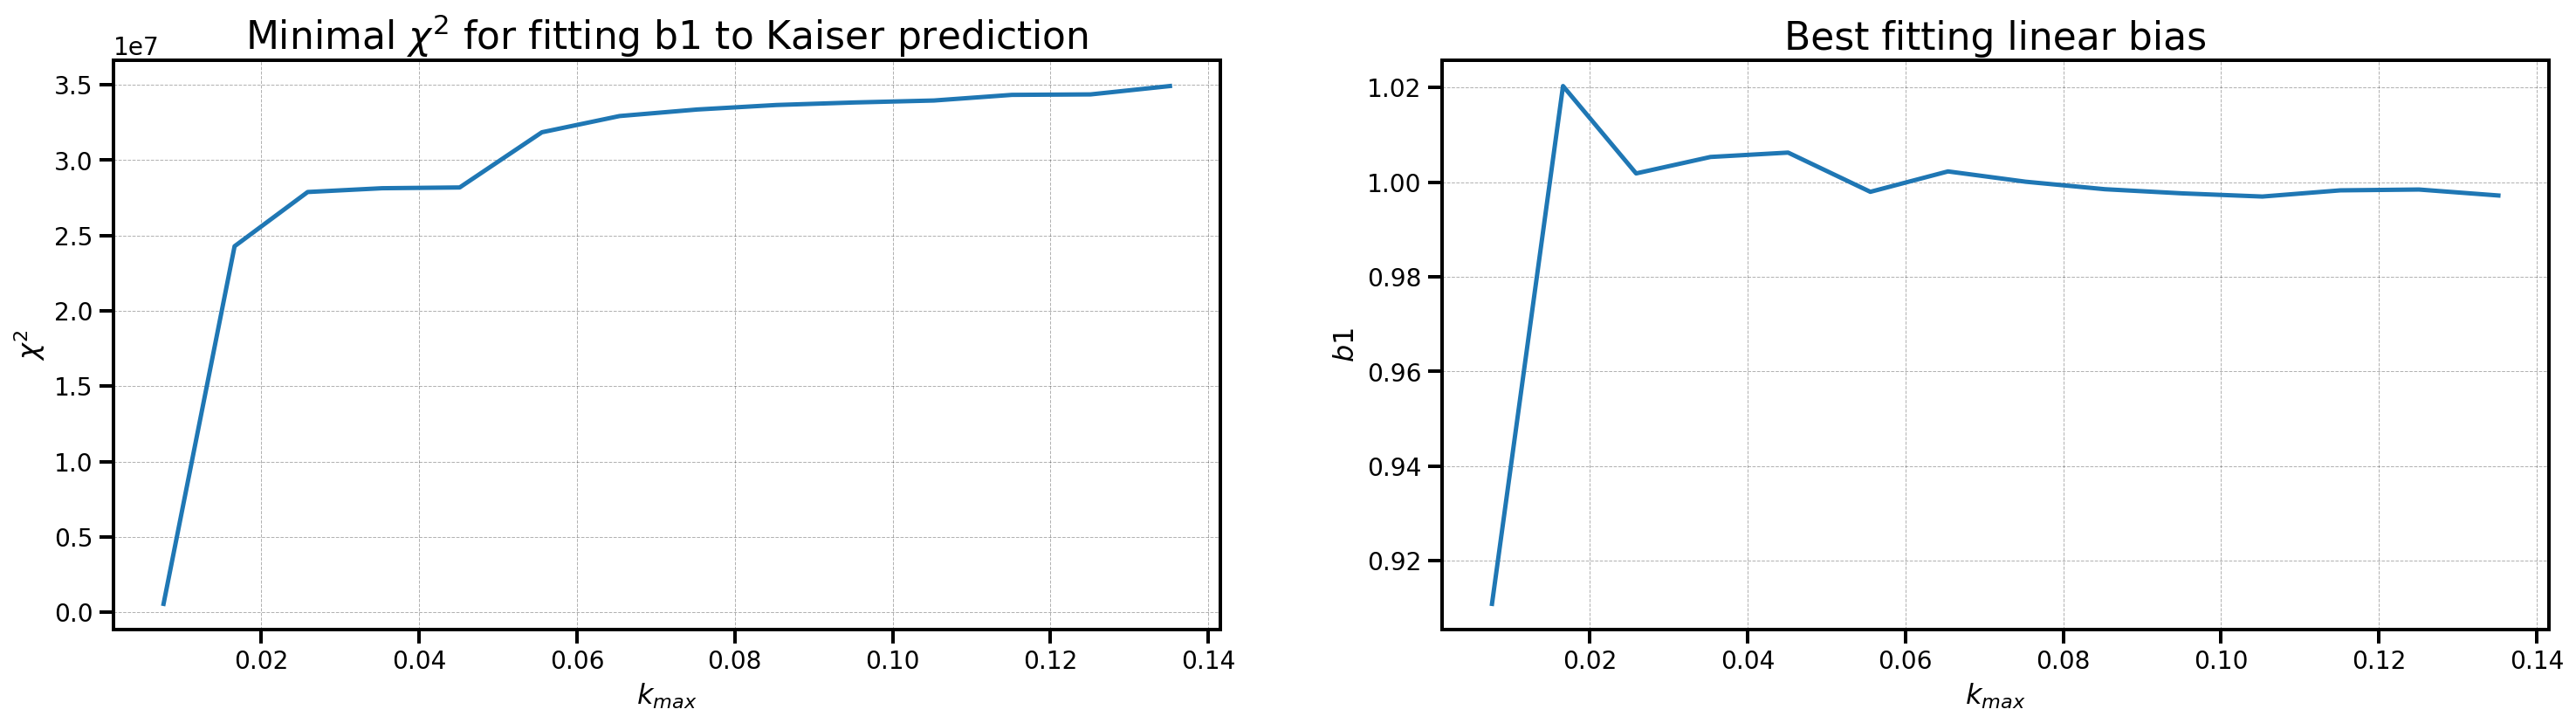

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,6))

ax1.plot(k, chi2_mins)
ax1.set_title('Minimal $\chi^2$ for fitting b1 to Kaiser prediction')
ax1.set_xlabel('$k_{max}$')
ax1.set_ylabel('$\chi^2$')

ax2.plot(k, b1_fits)
ax2.set_title('Best fitting linear bias')
ax2.set_xlabel('$k_{max}$')
ax2.set_ylabel('$b1$')

plt.show()
fname = 'plots/chi2_minimization.pdf'
#fig.savefig(fname)

The larger `Nmesh`, the greater `kmax` and thus the further we enter the non-linear regime. Thus we expect the difference between data and linear theory to grow such that $\chi^2$ becomes large. 